# Clasificación Multiclase de Plantas de Energía

## 1. Carga y preprocesamiento del dataset

Para esta sección del proyecto, trabajamos con el dataset **Global Power Plant Database**, el cual contiene información técnica y geográfica de miles de plantas eléctricas a nivel mundial.

El objetivo de este modelo es **predecir el tipo de fuente primaria de energía** que utiliza una planta eléctrica (e.g. Solar, Hydro, Gas, etc.) a partir de sus características:

- **Capacidad instalada (`capacity_mw`)**
- **Latitud geográfica (`latitude`)**
- **Longitud geográfica (`longitude`)**
- **Año de construcción (`commissioning_year`)**

### 🔹 Preprocesamiento aplicado

- Se seleccionaron únicamente las **8 clases más frecuentes**: Solar, Hydro, Wind, Gas, Coal, Oil, Biomass y Waste.
- Se eliminaron las filas que contenían datos faltantes (`NaN`) para garantizar un entrenamiento limpio y sin ruido.
- Se codificaron las clases como **valores numéricos enteros** (0 a 7).
- Se normalizaron todas las características numéricas utilizando la fórmula estándar:

\[
X_{\text{norm}} = \frac{X - \mu}{\sigma}
\]

donde \( \mu \) es la media de la columna y \( \sigma \) la desviación estándar.

- Finalmente, se dividió el conjunto de datos en **80% entrenamiento** y **20% prueba**, utilizando un muestreo aleatorio reproducible con `numpy`.

---

In [68]:
# Reimportamos todo lo necesario tras reinicio
import pandas as pd
import numpy as np

# Paso 1: Cargar el dataset y filtrar solo las 8 clases más comunes
df = pd.read_csv("D:/IMPORTANTE/global_power_plant_database.csv")

# Seleccionamos las clases más comunes
clases_objetivo = ['Solar', 'Hydro', 'Wind', 'Gas', 'Coal', 'Oil', 'Biomass', 'Waste']
df = df[df['primary_fuel'].isin(clases_objetivo)].copy()

# Nos quedamos solo con las columnas relevantes
df = df[['capacity_mw', 'latitude', 'longitude', 'commissioning_year', 'primary_fuel']]

# Eliminamos filas con valores nulos
df = df.dropna()

# Codificamos las clases como enteros
clases_unicas = sorted(df['primary_fuel'].unique())
label_dict = {name: i for i, name in enumerate(clases_unicas)}
df['primary_fuel'] = df['primary_fuel'].map(label_dict)

# Extraemos X e y
X = df[['capacity_mw', 'latitude', 'longitude', 'commissioning_year']].to_numpy()
y = df['primary_fuel'].to_numpy()

# Normalizamos X manualmente
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X = (X - mu) / sigma

# División manual del dataset en entrenamiento y prueba
np.random.seed(42)
m = X.shape[0]
indices = np.random.permutation(m)
m_train = int(m * 0.8)

train_idx = indices[:m_train]
test_idx = indices[m_train:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Verificamos las dimensiones
X_train.shape, y_train.shape, X_test.shape, y_test.shape


C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_9984\2863057633.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:/IMPORTANTE/global_power_plant_database.csv")


((13623, 4), (13623,), (3406, 4), (3406,))

## 📊 1. Exploración inicial del dataset

Antes de entrenar el modelo, realizamos una exploración básica para comprender mejor los datos disponibles.

### 🔹 Primeras filas del dataset

Se muestran las primeras filas del dataset ya filtrado y limpio, que incluyen las variables que serán utilizadas como entrada y la clase objetivo (`primary_fuel` codificada numéricamente).

Esto nos permite verificar que la estructura sea la esperada y que no haya valores inconsistentes o errores de formato.

### 🔹 Estadísticas descriptivas

Se calcula un resumen estadístico con medidas como la **media**, **mínimo**, **máximo**, **desviación estándar** y **cuartiles** de las variables numéricas:

- Capacidad de generación (`capacity_mw`)
- Latitud
- Longitud
- Año de construcción (`commissioning_year`)

Estas estadísticas son útiles para detectar posibles valores atípicos y comprender el rango de valores que manejará el modelo.



In [69]:
# Mostrar los primeros registros
print("Primeras filas del dataset:")
display(df.head())


Primeras filas del dataset:


,capacity_mw,latitude,longitude,commissioning_year,primary_fuel
9,27.0,39.9116,20.1047,1965.0,3
10,500.0,42.2514,20.0431,1978.0,3
11,600.0,42.1033,19.8224,1985.0,3
12,5.0,41.3428,19.8964,1951.0,3
13,24.0,41.6796,19.8305,1963.0,3


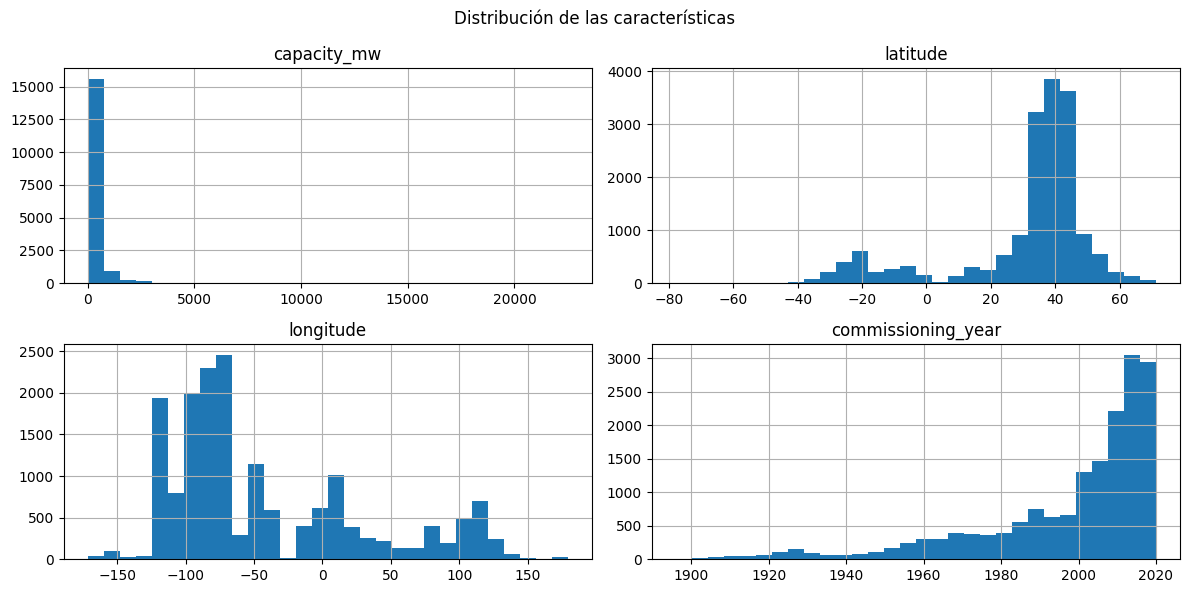

In [70]:
import matplotlib.pyplot as plt

df[['capacity_mw', 'latitude', 'longitude', 'commissioning_year']].hist(bins=30, figsize=(12, 6))
plt.suptitle("Distribución de las características")
plt.tight_layout()
plt.show()


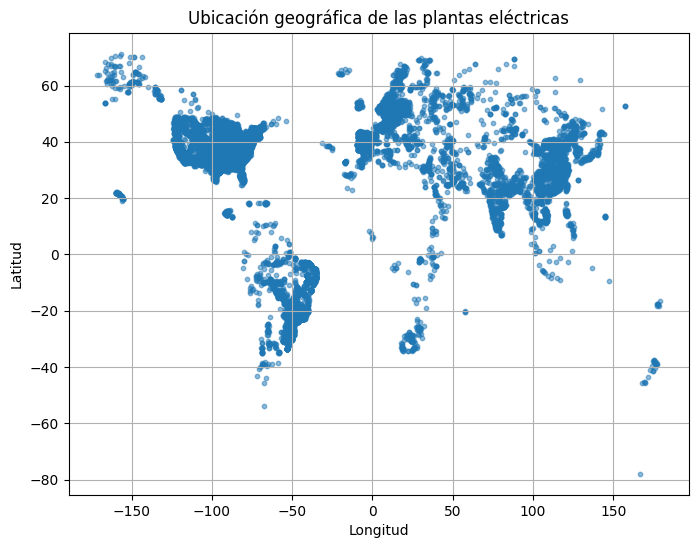

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], alpha=0.5, s=10)
plt.title("Ubicación geográfica de las plantas eléctricas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()


Características (X):
     capacity_mw  latitude  longitude  commissioning_year
9          27.0   39.9116    20.1047              1965.0
10        500.0   42.2514    20.0431              1978.0
11        600.0   42.1033    19.8224              1985.0
12          5.0   41.3428    19.8964              1951.0
13         24.0   41.6796    19.8305              1963.0

Etiquetas codificadas (y):
 9     3
10    3
11    3
12    3
13    3
Name: primary_fuel, dtype: int64

Diccionario de clases: {'Biomass': 0, 'Coal': 1, 'Gas': 2, 'Hydro': 3, 'Oil': 4, 'Solar': 5, 'Waste': 6, 'Wind': 7}

Cantidad total de ejemplos: 17029
Ejemplos de entrenamiento: 13623
Ejemplos de prueba: 3406


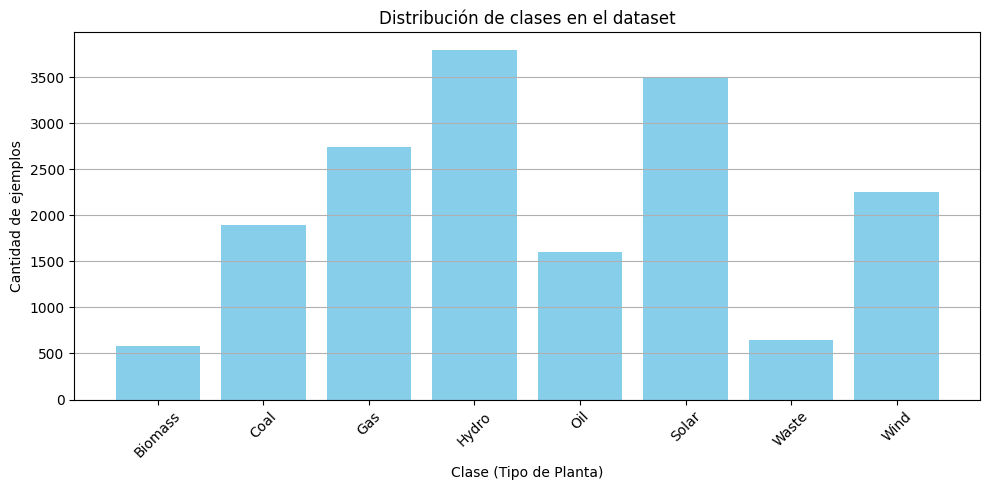

In [72]:
import matplotlib.pyplot as plt

print("Características (X):\n", df[['capacity_mw', 'latitude', 'longitude', 'commissioning_year']].head())
print("\nEtiquetas codificadas (y):\n", df['primary_fuel'].head())
print("\nDiccionario de clases:", label_dict)
print(f"\nCantidad total de ejemplos: {len(X)}")
print(f"Ejemplos de entrenamiento: {len(X_train)}")
print(f"Ejemplos de prueba: {len(X_test)}")

# Conteo de clases
conteo_clases = np.bincount(y)
clases_nombres = [nombre for nombre, idx in sorted(label_dict.items(), key=lambda x: x[1])]

# Gráfico de barras para clases
plt.figure(figsize=(10, 5))
plt.bar(clases_nombres, conteo_clases, color='skyblue')
plt.xlabel("Clase (Tipo de Planta)")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases en el dataset")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos funciones auxiliares
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Estabilidad numérica
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, num_clases):
    m = y.shape[0]
    one_hot_matrix = np.zeros((m, num_clases))
    one_hot_matrix[np.arange(m), y] = 1
    return one_hot_matrix

def cross_entropy(y_hat, y_true):
    m = y_true.shape[0]
    y_onehot = one_hot(y_true, y_hat.shape[1])
    log_probs = np.log(y_hat + 1e-9)  # evitar log(0)
    loss = -np.sum(y_onehot * log_probs) / m
    return loss

# Inicializamos pesos y bias
np.random.seed(42)
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
W = np.random.randn(n_features, n_classes) * 0.01
b = np.zeros((1, n_classes))

# Hiperparámetros
epochs = 5000
learning_rate = 0.1
loss_history = []

# Entrenamiento
for epoch in range(epochs):
    z = np.dot(X_train, W) + b
    y_hat = softmax(z)
    loss = cross_entropy(y_hat, y_train)
    loss_history.append(loss)

    m = y_train.shape[0]
    y_onehot = one_hot(y_train, n_classes)
    dz = (y_hat - y_onehot) / m
    dW = np.dot(X_train.T, dz)
    db = np.sum(dz, axis=0, keepdims=True)

    W -= learning_rate * dW
    b -= learning_rate * db

    if epoch % 500 == 0 or epoch == epochs - 1:
        print(f"Época {epoch} - Pérdida: {loss:.4f}")


Época 0 - Pérdida: 2.0809
Época 500 - Pérdida: 1.3278
Época 1000 - Pérdida: 1.2905
Época 1500 - Pérdida: 1.2728
Época 2000 - Pérdida: 1.2617
Época 2500 - Pérdida: 1.2540
Época 3000 - Pérdida: 1.2481
Época 3500 - Pérdida: 1.2435
Época 4000 - Pérdida: 1.2397
Época 4500 - Pérdida: 1.2366
Época 4999 - Pérdida: 1.2340


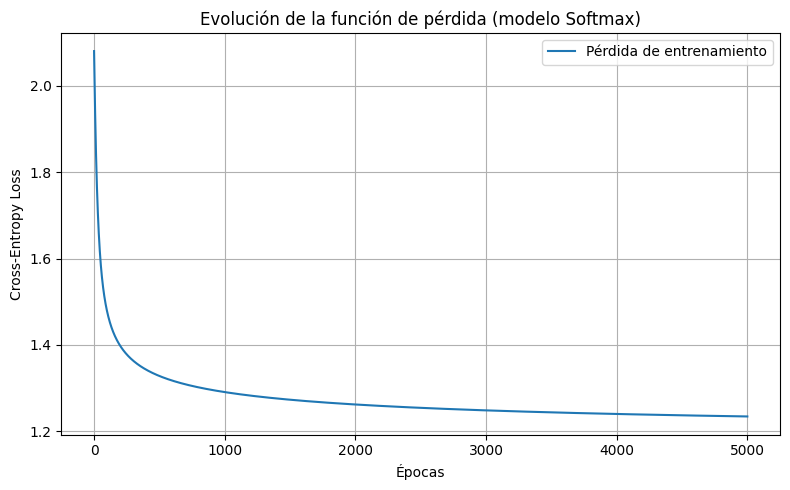

In [74]:
# GRÁFICO DE LA FUNCIÓN DE COSTO
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Pérdida de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Cross-Entropy Loss")
plt.title("Evolución de la función de pérdida (modelo Softmax)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [75]:
z_test = np.dot(X_test, W) + b
y_hat_test = softmax(z_test)
y_pred_test = np.argmax(y_hat_test, axis=1)

accuracy = np.mean(y_pred_test == y_test) * 100
print(f"Precisión en conjunto de prueba: {accuracy:.2f}%")


Precisión en conjunto de prueba: 57.43%


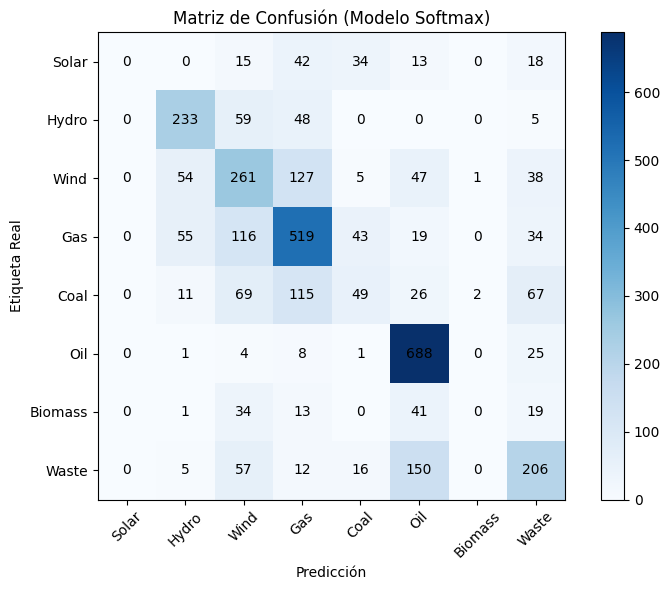

In [76]:
import matplotlib.pyplot as plt

# Crear matriz de confusión manual
confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)

for true_label, pred_label in zip(y_test, y_pred_test):
    confusion_matrix[true_label, pred_label] += 1

# Mostrar matriz como heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matriz de Confusión (Modelo Softmax)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.colorbar()

# Etiquetas de clase
plt.xticks(np.arange(n_classes), clases_objetivo, rotation=45)
plt.yticks(np.arange(n_classes), clases_objetivo)

# Números en las celdas
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.grid(False)
plt.show()


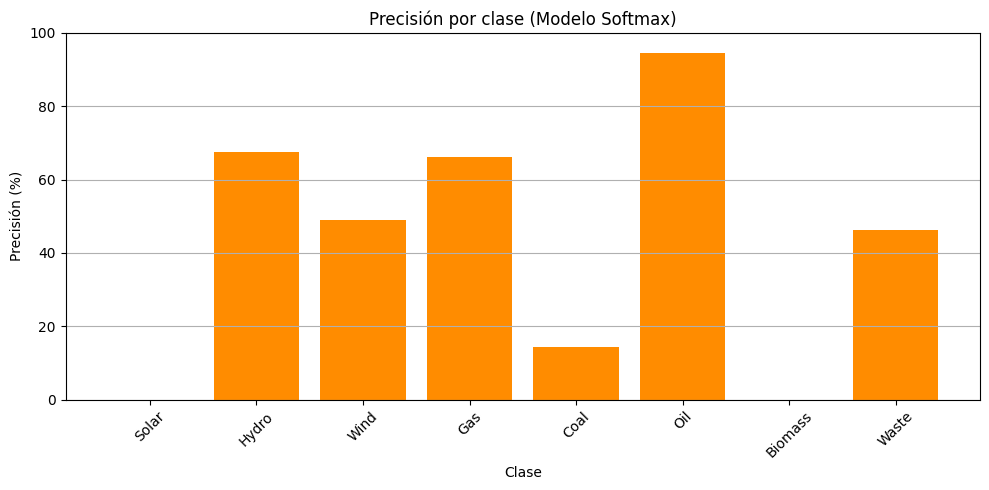

Solar     : 0.00%
Hydro     : 67.54%
Wind      : 48.97%
Gas       : 66.03%
Coal      : 14.45%
Oil       : 94.64%
Biomass   : 0.00%
Waste     : 46.19%


In [77]:
import matplotlib.pyplot as plt

precision_por_clase = []

for i in range(n_classes):
    verdaderos = (y_test == i)
    predichos_correctamente = (y_pred_test == i) & verdaderos
    precision = predichos_correctamente.sum() / max(verdaderos.sum(), 1)
    precision_por_clase.append(precision * 100)

# Gráfico de precisión por clase
plt.figure(figsize=(10, 5))
plt.bar(clases_objetivo, precision_por_clase, color='darkorange')
plt.ylabel("Precisión (%)")
plt.xlabel("Clase")
plt.title("Precisión por clase (Modelo Softmax)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# También mostramos en texto
for i, clase in enumerate(clases_objetivo):
    print(f"{clase:10s}: {precision_por_clase[i]:.2f}%")
